# Libraries

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Import Data

In [2]:
df = pd.read_csv("data/raw/retail_store_inventory.csv") # Load csv data
df.head() # see snipset data

,Date,Store ID,Product ID,Category,Region,Inventory Level,Units Sold,Units Ordered,Demand Forecast,Price,Discount,Weather Condition,Holiday/Promotion,Competitor Pricing,Seasonality
0,2022-01-01,S001,P0001,Groceries,North,231,127,55,135.47,33.50,20,Rainy,0,29.69,Autumn
1,2022-01-01,S001,P0002,Toys,South,204,150,66,144.04,63.01,20,Sunny,0,66.16,Autumn
2,2022-01-01,S001,P0003,Toys,West,102,65,51,74.02,27.99,10,Sunny,1,31.32,Summer
3,2022-01-01,S001,P0004,Toys,North,469,61,164,62.18,32.72,10,Cloudy,1,34.74,Autumn
4,2022-01-01,S001,P0005,Electronics,East,166,14,135,9.26,73.64,0,Sunny,0,68.95,Summer


# Data Inspection 

## Data Structure

In [3]:
print("Shape:", df.shape)            # rows × cols 
df.info()                            # dtypes + non-null counts

Shape: (73100, 15)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 73100 entries, 0 to 73099
Data columns (total 15 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Date                73100 non-null  object 
 1   Store ID            73100 non-null  object 
 2   Product ID          73100 non-null  object 
 3   Category            73100 non-null  object 
 4   Region              73100 non-null  object 
 5   Inventory Level     73100 non-null  int64  
 6   Units Sold          73100 non-null  int64  
 7   Units Ordered       73100 non-null  int64  
 8   Demand Forecast     73100 non-null  float64
 9   Price               73100 non-null  float64
 10  Discount            73100 non-null  int64  
 11  Weather Condition   73100 non-null  object 
 12  Holiday/Promotion   73100 non-null  int64  
 13  Competitor Pricing  73100 non-null  float64
 14  Seasonality         73100 non-null  object 
dtypes: float64(3), int64(5), object(7)

- Terdapat 73.100 baris data
- Terdapat 15 kolom
- Tidak ada null values dari setiap kolom 

## Correcting Data Format

- Kolom "Date" masih dalam bentuk string sehingga perlu diubah
- (optional) Mengubah kolom Nominal & ID menjadi type categorical
- (optional) Mengubah kolom boolean menjadi type boolean
- (optional) Convert kolom numeric 

In [4]:
# Change date column from object to datetime
df["Date"] = pd.to_datetime(df["Date"])               

# Change Nominals & IDs from object to category → category to shrink memory and speed joins
cat_cols = ["Store ID", "Product ID", "Category",
            "Region", "Weather Condition", "Seasonality"]
df[cat_cols] = df[cat_cols].astype("category")

# Change Binary flag to boolean
df["Holiday/Promotion"] = df["Holiday/Promotion"].astype("bool")

# Make sure numeric columns are truly numeric
num_cols = ["Inventory Level", "Units Sold", "Units Ordered",
            "Demand Forecast", "Price", "Discount",
            "Competitor Pricing"]
df[num_cols] = df[num_cols].apply(pd.to_numeric, errors="coerce")

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 73100 entries, 0 to 73099
Data columns (total 15 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   Date                73100 non-null  datetime64[ns]
 1   Store ID            73100 non-null  category      
 2   Product ID          73100 non-null  category      
 3   Category            73100 non-null  category      
 4   Region              73100 non-null  category      
 5   Inventory Level     73100 non-null  int64         
 6   Units Sold          73100 non-null  int64         
 7   Units Ordered       73100 non-null  int64         
 8   Demand Forecast     73100 non-null  float64       
 9   Price               73100 non-null  float64       
 10  Discount            73100 non-null  int64         
 11  Weather Condition   73100 non-null  category      
 12  Holiday/Promotion   73100 non-null  bool          
 13  Competitor Pricing  73100 non-null  float64   

## Filtering Out Irrelevant Variables

Drop kolom yang tidak diperlukan untuk forecasting

In [6]:
drop_columns = ["Inventory Level", "Demand Forecast"]
df.drop(columns = drop_columns, inplace = True)

## Missing Value

In [7]:
# Re-scan for NaNs created by our dtype coercion
print(df.isna().sum())

Date                  0
Store ID              0
Product ID            0
Category              0
Region                0
Units Sold            0
Units Ordered         0
Price                 0
Discount              0
Weather Condition     0
Holiday/Promotion     0
Competitor Pricing    0
Seasonality           0
dtype: int64


Tidak terdapat null values. Code dibawah adalah contoh handling jika ada missing values

In [8]:
# Contoh kl misal ada missing values

# 1. Create identifier null or not before filling to retain original data
for col in df.columns:
    if df[col].isna().any():
        df[f"{col}_is_null"] = df[col].isna()
        
# 2. Create fill rules
fill_rules = {
    "Units Sold"      : 0,                               # target: assume no sale
    "Price"           : df["Price"].median(),
    "Discount"        : 0,
}

df = df.fillna(value=fill_rules)

# 3. Fillna Categorical NaNs → 'Unknown'
for c in df.select_dtypes("category"):
    if df[c].isna().any():
        df[c] = df[c].cat.add_categories("Unknown").fillna("Unknown")

## Outlier Checking

Outlier checking menggunakan metode IQR dengan whisker 1.5

In [9]:
def add_outlier_flags(
        data: pd.DataFrame,
        numeric_cols: list[str] | None = None,
        group_cols:  list[str] | None = None,
        whisker: float = 1.5
    ) -> pd.DataFrame:
    """
    Adds a boolean `<col>_is_outlier` flag to *data* for each numeric column.

    Parameters
    ----------
    data : pd.DataFrame
        DataFrame to operate on (Flag columns are added in-place & returned).
    numeric_cols : list[str] | None
        If None, detect all numeric dtypes automatically.
    group_cols : list[str] | None
        Columns to group by before computing IQR fences.
        • []  or None  → global fences over the entire column
        • ["Store ID"] → per-store fences … etc.
    whisker : float
        Multiplier for IQR; 1.5 ≡ Tukey’s default.

    Returns
    -------
    pd.DataFrame  (same object, for chaining convenience)
    """
    if numeric_cols is None:
        numeric_cols = data.select_dtypes(include="number").columns.tolist()

    # Work on a copy of index to broadcast flags back
    flags = pd.DataFrame(index=data.index)

    if not group_cols:
        # -------- global IQR fences --------
        for col in numeric_cols:
            q1, q3 = data[col].quantile([0.25, 0.75])
            iqr  = q3 - q1
            lo   = q1 - whisker * iqr
            hi   = q3 + whisker * iqr
            flags[f"{col}_is_outlier"] = (data[col] < lo) | (data[col] > hi)
    else:
        # -------- group-wise IQR fences --------
        grouped = data.groupby(group_cols, observed=True, dropna=False)
        for col in numeric_cols:
            # Compute group stats and re-index back to original rows
            q1 = grouped[col].transform("quantile", 0.25)
            q3 = grouped[col].transform("quantile", 0.75)
            iqr = q3 - q1
            lo  = q1 - whisker * iqr
            hi  = q3 + whisker * iqr
            flags[f"{col}_is_outlier"] = (data[col] < lo) | (data[col] > hi)

    # Attach the flags
    for c in flags.columns:
        data[c] = flags[c].astype(bool)

    return data

In [10]:
# Add outlier flag
df = add_outlier_flags(data = df, whisker = 1.5, group_cols = ["Store ID", "Product ID"])

In [11]:
# Print percentage outlier
numeric_cols = df.select_dtypes(include="number").columns.tolist()

pct_dict = {}
total = len(df)
for col in numeric_cols:
    flag = f"{col}_is_outlier"
    if flag in df.columns:
        pct_dict[col] = round(df[flag].mean() * 100, 2)

# Print percentage outlier
print("Outlier percentage (%) per column")
print("—" * 34)
for col, pct in sorted(pct_dict.items(), key=lambda x: -x[1]):
    print(f"{col:<25s} : {pct:>6.2f}")

Outlier percentage (%) per column
——————————————————————————————————
Units Sold                :   1.11
Units Ordered             :   0.00
Price                     :   0.00
Discount                  :   0.00
Competitor Pricing        :   0.00


Pada units sold terdapat outlier sejumlah 1.11%. Outlier detection menggunakan group by store & product karena ada produk yang fast moving, slow moving begitu juga dengan store ada store yang besar maupun store kecil

Store ID  Product ID
S004      P0012         23
          P0007         22
S003      P0018         22
dtype: int64


/tmp/ipykernel_3979402/3926438496.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby(['Store ID', 'Product ID'])


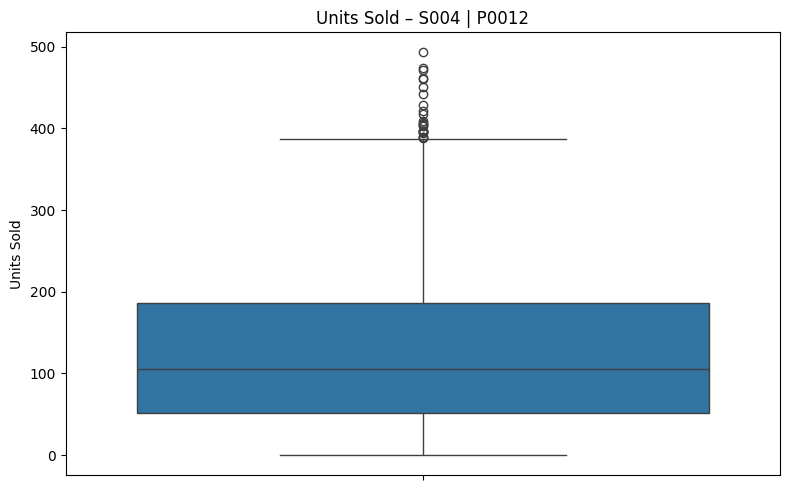

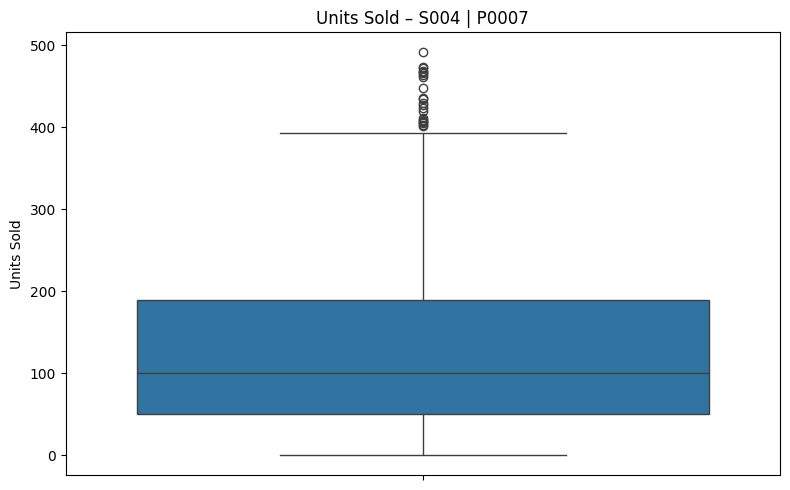

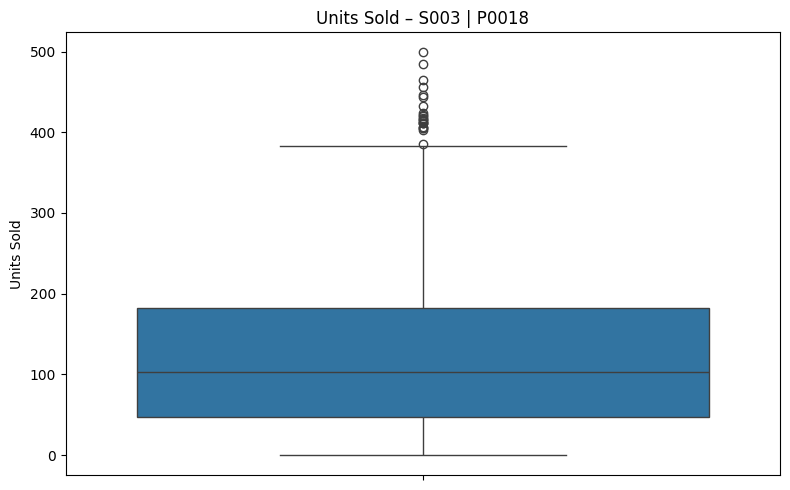

In [12]:
# Cari 3 store x product yg punya outlier terbanyak
outlier_counts = (
    df[df['Units Sold_is_outlier']]
      .groupby(['Store ID', 'Product ID'])
      .size()
      .sort_values(ascending=False)
)
top3 = outlier_counts.head(3)
print(top3)

# Plot outlier
for (store_id, product_id), _ in top3.items():
    subset = df[(df['Store ID'] == store_id) & (df['Product ID'] == product_id)]
    label = f"{store_id} | {product_id}"
    
    plt.figure(figsize=(8, 5))
    sns.boxplot(y=subset['Units Sold'])
    plt.title(f"Units Sold – {label}")
    plt.ylabel("Units Sold")
    plt.xlabel("")
    plt.tight_layout()
    plt.show()

Interpretasi plot
- Data point yang diluar garis horizontal hitam adalah outlier

# Wrap Up and Save the Data

In [13]:
df.to_parquet("data/preprocessed/df_preprocessed.parquet", index = False)